In [1]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
from tqdm.auto import trange
import itertools as it
import h5py

import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

import torch

from sca import *

In [2]:

it_count1  = []

def SCA_(h, mu, Pc, Pmax, pt = None, MaxIter = 10000, SolverMaxIter = 1000,
         parm_alpha = 1e-8, parm_beta = 0.01, 
         RelTolFun = 1e-12, RelTolVal = 1e-12, it=None):

    if pt is None:
        pt = np.full(h.shape[-1], Pmax)

    def f(p): # verified
        s = h * p # (4,4) * (4,) --> (4,4)
        
        direct = np.diag(s)
        ifn = 1 + np.sum(s, axis=-1) - direct
        rates = np.log(1+direct/ifn)
        ee = rates / (mu * p + Pc)

        return np.sum(ee)

    def gradr(p): # verified
        s = h * p
        tmp = 1 + np.sum(s, axis=-1) # 1 + sum beta + a
        tmp2 = tmp - np.diag(s)
        fac = np.diag(s) / (tmp * tmp2)
        
        grad = h.copy()      
        grad = -(fac * grad.T).T
    
        grad[np.diag_indices_from(grad)] = 1/tmp * np.diag(h)#tmp2/(tmp*tmp2) * np.diag(h)

        return grad

    def gradf(p): # verified
        tmp = 1 / (mu * p + Pc)
        gr = gradr(p)
        
        t1 = np.sum((gr.T * tmp).T, axis=0)

        s = h * p
        direct = np.diag(s)
        ifn = 1 + np.sum(s, axis=-1) - direct
        rates = np.log(1+direct/ifn)
        
        t2 = mu * rates * tmp**2

        return t1 - t2

    # gradient step parameter
    OBJ, PT = [],[]
    
    cnt = 0
    obj = f(pt)
    while True:
        
        OBJ.append(obj)
        PT.append(pt)
        
        cnt += 1

        # grad r (without main diagonal)
        s = h * pt
#         print(h, pt)
        
        tmp = 1 + np.sum(s, axis=-1) # 1 + sum beta + a
        tmp2 = tmp - np.diag(s)

        fac = np.diag(s) / (tmp * tmp2)

        beta = h.copy()
        beta[np.diag_indices_from(beta)] = 0
        grad = -(fac * beta.T).T
        
        # r tilde constants
        txp = 1.0/(mu * pt + Pc)
        
        c1 = np.sum(grad * txp , axis=0)
        c2 = -mu * np.log(np.diag(s)/tmp2+1)*txp**2
        
        c = c1+c2
                
        d = -c * pt    
    
        # ----- solve inner problem -----
        pvar = cp.Variable(pt.shape[0])
        obj_nl = cp.log(cp.multiply(np.diag(h)/tmp2, pvar)+1) @ txp ##
        obj_l  = cp.multiply(c, pvar)
        
        objective = cp.Maximize(cp.sum(obj_nl + obj_l + d))
        constraints = [0 <= pvar, pvar <= Pmax]
        prob = cp.Problem(objective, constraints)
                 
        print(it,'-outer it#', cnt)
        print('before solver:', pvar.value, pt)
        prob.solve(requires_grad=True, eps=1e-8, max_iters=SolverMaxIter, verbose=True)

        print('after solver:', pvar.value, pt,'\n')
        # --------------------------------
            
        # calculate gradient step
        Bpt = pvar.value - pt
        gamma = 1

        old_obj = obj # f(pt)
        old_pt = pt
        while f(pt + gamma * Bpt) < old_obj + parm_alpha * gamma * gradf(pt) @ Bpt:
            gamma *= parm_beta

        pt += gamma * Bpt
        obj = f(pt)

        with np.errstate(divide='ignore'):
            if abs(obj/old_obj - 1) < RelTolFun and np.linalg.norm(pt-old_pt, np.inf) / np.linalg.norm(pt, np.inf) < RelTolVal:
                break
        
        if cnt > MaxIter:
            print('MaxIter')
            break

    it_count1.append(cnt)
    return (OBJ, PT)

In [3]:

class grad_solver_1step(torch.nn.Module):
    def __init__(self, pt0, h, Pmax, Pc, mu):
        super().__init__()
        
        self.h = torch.from_numpy(h).float()
        self.mu = torch.tensor(mu).float()
        self.Pc = torch.tensor(Pc).float()
        self.Pmax = torch.tensor(Pmax).float()
        
        s = h * pt0

        tmp = 1 + np.sum(s, axis=-1) # 1 + sum beta + a
        tmp2 = tmp - np.diag(s) #
        fac = np.diag(s) / (tmp * tmp2)
        beta = h.copy()
        beta[np.diag_indices_from(beta)] = 0
        grad = -(fac * beta.T).T

        # r tilde constants
        txp = 1.0/(mu * pt0 + Pc)
        c1 = np.sum(grad * txp , axis=0)
        c2 = -mu * np.log(np.diag(s)/tmp2+1)*txp**2
        c = c1+c2 #
        d = -c * pt0 #
        
        self.txp = torch.from_numpy(txp).float()
        self.tmp = torch.from_numpy(tmp).float()
        self.tmp2 = torch.from_numpy(tmp2).float()
        self.c = torch.from_numpy(c).float()
        self.d = torch.from_numpy(d).float()

        # initialize 
        self.pvar = torch.nn.Parameter(
            torch.tensor(pt0, requires_grad=True).float() # should be trainable parameter
        )
        torch.nn.init.uniform_(self.pvar, a=0.0, b=self.Pmax)
    
        
    def forward(self):
        #obj_nl = cp.log(cp.multiply(np.diag(h)/tmp2, pvar)+1) @ txp
        obj_nl = torch.log((torch.diag(self.h)/self.tmp2) * self.pvar + 1) @ self.txp
        #obj_l  = cp.multiply(c, pvar)
        obj_l  = self.c * self.pvar
                
        return -1*(obj_nl+obj_l+self.d) 
    
    def ee(self, p):
        s = self.h * p # (4,4) * (4,) --> (4,4)

        direct = torch.diag(s)
        ifn = 1 + torch.sum(s, axis=-1) - direct
        rates = torch.log(1+direct/ifn)
        ee = rates / (self.mu * p + self.Pc)

        return np.sum(ee)  
    
    
    
    
def SCA_(h, mu, Pc, Pmax, pt = None, MaxIter = 10000, SolverMaxIter = 1000,
         parm_alpha = 1e-8, parm_beta = 0.01, 
         RelTolFun = 1e-12, RelTolVal = 1e-12, it=None):

    if pt is None:
        pt = np.full(h.shape[-1], Pmax)

    def f(p): # verified
        s = h * p # (4,4) * (4,) --> (4,4)
        
        direct = np.diag(s)
        ifn = 1 + np.sum(s, axis=-1) - direct
        rates = np.log(1+direct/ifn)
        ee = rates / (mu * p + Pc)

        return np.sum(ee)

    def gradr(p): # verified
        s = h * p
        tmp = 1 + np.sum(s, axis=-1) # 1 + sum beta + a
        tmp2 = tmp - np.diag(s)
        fac = np.diag(s) / (tmp * tmp2)
        
        grad = h.copy()      
        grad = -(fac * grad.T).T
    
        grad[np.diag_indices_from(grad)] = 1/tmp * np.diag(h)#tmp2/(tmp*tmp2) * np.diag(h)

        return grad

    def gradf(p): # verified
        tmp = 1 / (mu * p + Pc)
        gr = gradr(p)
        
        t1 = np.sum((gr.T * tmp).T, axis=0)

        s = h * p
        direct = np.diag(s)
        ifn = 1 + np.sum(s, axis=-1) - direct
        rates = np.log(1+direct/ifn)
        
        t2 = mu * rates * tmp**2

        return t1 - t2

    # gradient step parameter
    OBJ, PT = [],[]
    
    cnt = 0
    obj = f(pt)
    while True:
        
        OBJ.append(obj)
        PT.append(pt)
        
        cnt += 1
        
        # solve innner optim pvar
        model = grad_solver_1step(pt, h, Pmax, Pc, mu)
        opt = torch.optim.SGD(model.parameters(), lr=0.1)

        ll=[]
        ee=[]
        for i in range(SolverMaxIter):

            loss = model()

            ll.append([l.item() for l in loss])
            ee.append(f(model.pvar.detach().numpy()))

            opt.zero_grad()
            loss.backward(torch.ones(4))
            opt.step()

            with torch.no_grad():
                for param in model.parameters():
                    param.clamp_(0, Pmax)            
        
        
        # calculate gradient step
        Bpt = model.pvar.detach().numpy() - pt
        gamma = 1

        old_obj = obj # f(pt)
        old_pt = pt
        while f(pt + gamma * Bpt) < old_obj + parm_alpha * gamma * gradf(pt) @ Bpt:
            gamma *= parm_beta

        pt += gamma * Bpt
        obj = f(pt)

        with np.errstate(divide='ignore'):
            if abs(obj/old_obj - 1) < RelTolFun and np.linalg.norm(pt-old_pt, np.inf) / np.linalg.norm(pt, np.inf) < RelTolVal:
                break
        
        if cnt > MaxIter:
            print('MaxIter')
            break

    it_count1.append(cnt)
    return (OBJ, PT)

In [4]:
num_ue = 4
mu = 4
Pc = 1

inits = ['last','full','rand']

MONITOR = {
    'objective':dict(zip(inits,[[] for _ in inits])),
    'pwr_alloc':dict(zip(inits,[[] for _ in inits]))
}


PdB = np.array(range(-30,20+1,1)) #51

dfn1 = '../../data/wsee%d-processed.h5'%num_ue
with h5py.File(dfn1, "r") as f:
    Plin = 10**(np.asarray(f['input']['PdB'][...]/10))

dfn2 = '../../data_my/channels-%d.h5'%num_ue
with h5py.File(dfn2, "r") as f:
    # Get the data
    data = {k:{kk: v[:] for kk,v in f[k].items()} for k in f.keys()}
#     print(''.join(data['channel_generation']['source code']))
    
    Hs = data['input']['channel_to_noise_matched']
    
    for hidx in trange(Hs.shape[0]):
        
        h = Hs[hidx]
        pt = None
    
        for pidx in tqdm(np.random.permutation(len(Plin))):
            
#             if pidx!=42:
#                 continue
                
            p = Plin[pidx]
            print('*','Pmax =', p)

            O = dict(zip(inits,[[] for _ in inits]))
            P = dict(zip(inits,[[] for _ in inits]))
            
            # last init
            istr = 'last'
            if pt is not None:
                O[istr], P[istr] = SCA_(h, mu, Pc, Pmax = p, pt = pt, SolverMaxIter=200, MaxIter = 10000, 
                              parm_alpha = 1e-8, parm_beta = 0.01, RelTolFun = 1e-12, RelTolVal = 1e-12, 
                              it=[pidx,'init: %s'%istr])
            else:
                O[istr], P[istr] = [-np.inf], [np.full(num_ue, p)]
            o1, p1 = O[istr][-1], P[istr][-1]

            # max initialization
            istr = 'full'
            O[istr], P[istr] = SCA_(h, mu, Pc, Pmax = p, pt = np.full(num_ue, p), SolverMaxIter=200, MaxIter = 10000, 
                          parm_alpha = 1e-8, parm_beta = 0.01, RelTolFun = 1e-12, RelTolVal = 1e-12, 
                          it=[pidx,'init: %s'%istr])
            o2, p2 = O[istr][-1], P[istr][-1]
            
            # random initialization
            istr = 'rand'
            O[istr], P[istr] = SCA_(h, mu, Pc, Pmax = p, pt = np.array([np.random.uniform()*p for _ in range(num_ue)]), MaxIter = 10000, 
                          parm_alpha = 1e-8, parm_beta = 0.01, RelTolFun = 1e-12, RelTolVal = 1e-12,
                          it=[pidx,'init: %s'%istr])
            o3, p3 = O[istr][-1], P[istr][-1]  
            
            
            bstr = max(O, key=lambda key: O[key][-1]) # best init
            pt = P[bstr][-1]
            
            print('%s init is best!'%bstr.upper(), 'objective ee =', O[bstr][-1], '#iters =', len(O[bstr]))
                
#             MONITOR['objective'] = {k:MONITOR['objective'].append(v) for k,v in zip(MONITOR['objective'].keys(),(O1,O2,O3))}
#             MONITOR['pwr_alloc'] = {k:MONITOR['pwr_alloc'].append(v) for k,v in zip(MONITOR['pwr_alloc'].keys(),(P1,P2,P3))}
             
        break

* Pmax = 39.810717055349734
RAND init is best! objective ee = 0.2788519997673196 #iters = 4
* Pmax = 12.589254117941675
RAND init is best! objective ee = 0.6518357418821059 #iters = 3
* Pmax = 0.1
FULL init is best! objective ee = 5.138791466214262 #iters = 1
* Pmax = 0.0199526231496888
LAST init is best! objective ee = 5.142331894009411 #iters = 9
* Pmax = 0.003981071705534973
LAST init is best! objective ee = 5.142331894009411 #iters = 1
* Pmax = 1.5848931924611136
LAST init is best! objective ee = 5.172366803583328 #iters = 4
* Pmax = 1.2589254117941673
LAST init is best! objective ee = 5.172366803583328 #iters = 1
* Pmax = 63.09573444801933
LAST init is best! objective ee = 5.1763136863617385 #iters = 3
* Pmax = 0.012589254117941675
LAST init is best! objective ee = 5.223018190875592 #iters = 27
* Pmax = 0.007943282347242814
LAST init is best! objective ee = 5.223018190875592 #iters = 1
* Pmax = 0.19952623149688797
LAST init is best! objective ee = 5.223018190875592 #iters = 1
* Pm

'full'

In [6]:
def f(p,h): # verified
    s = h * p # (4,4) * (4,) --> (4,4)

    direct = np.diag(s)
    ifn = 1 + np.sum(s, axis=-1) - direct
    rates = np.log(1+direct/ifn)
    ee = rates / (mu * p + Pc)

    return np.sum(ee)

def gradr(p,h): # verified
    s = h * p
    tmp = 1 + np.sum(s, axis=-1) # 1 + sum beta + a
    tmp2 = tmp - np.diag(s)
    fac = np.diag(s) / (tmp * tmp2)

    grad = h.copy()      
    grad = -(fac * grad.T).T

    grad[np.diag_indices_from(grad)] = 1/tmp * np.diag(h)#tmp2/(tmp*tmp2) * np.diag(h)

    return grad

def gradf(p,h,mu,Pc): # verified
    tmp = 1 / (mu * p + Pc)
    gr = gradr(p)

    t1 = np.sum((gr.T * tmp).T, axis=0)

    s = h * p
    direct = np.diag(s)
    ifn = 1 + np.sum(s, axis=-1) - direct
    rates = np.log(1+direct/ifn)

    t2 = mu * rates * tmp**2

    return t1 - t2

In [71]:
opt = optim.SGD(model.parameters(), lr=0.1)
for i in range(1000):
    out = model(inputs)
    loss = loss_fn(out, labels)
    print(i, loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        for param in model.parameters():
            param.clamp_(-1, 1)

5.2346960417705635

In [63]:
import torch

# ----- prepare parameters: tmp2, c, d -----
s = h * pt

tmp = 1 + np.sum(s, axis=-1) # 1 + sum beta + a
tmp2 = tmp - np.diag(s) #
fac = np.diag(s) / (tmp * tmp2)
beta = h.copy()
beta[np.diag_indices_from(beta)] = 0
grad = -(fac * beta.T).T

# r tilde constants
txp = 1.0/(mu * pt + Pc)
c1 = np.sum(grad * txp , axis=0)
c2 = -mu * np.log(np.diag(s)/tmp2+1)*txp**2
c = c1+c2 #
d = -c * pt #

# ------------------------------------------ 
    
# solve inner problem


class grad_solver_1step(torch.nn.Module):
    def __init__(self, pt0, h, Pmax, Pc, mu):
        super().__init__()
        
        self.h = torch.from_numpy(h).float()
        self.mu = torch.tensor(mu).float()
        self.Pc = torch.tensor(Pc).float()
        self.Pmax = torch.tensor(Pmax).float()
        
        s = h * pt0

        tmp = 1 + np.sum(s, axis=-1) # 1 + sum beta + a
        tmp2 = tmp - np.diag(s) #
        fac = np.diag(s) / (tmp * tmp2)
        beta = h.copy()
        beta[np.diag_indices_from(beta)] = 0
        grad = -(fac * beta.T).T

        # r tilde constants
        txp = 1.0/(mu * pt0 + Pc)
        c1 = np.sum(grad * txp , axis=0)
        c2 = -mu * np.log(np.diag(s)/tmp2+1)*txp**2
        c = c1+c2 #
        d = -c * pt0 #
        
        self.txp = torch.from_numpy(txp).float()
        self.tmp = torch.from_numpy(tmp).float()
        self.tmp2 = torch.from_numpy(tmp2).float()
        self.c = torch.from_numpy(c).float()
        self.d = torch.from_numpy(d).float()

        # initialize 
        self.pvar = torch.nn.Parameter(
            torch.tensor(pt, requires_grad=True).float() # should be trainable parameter
        )
        torch.nn.init.uniform_(self.pvar, a=0.0, b=self.Pmax)
    
        
    def forward(self):
        #obj_nl = cp.log(cp.multiply(np.diag(h)/tmp2, pvar)+1) @ txp
        obj_nl = torch.log((torch.diag(self.h)/self.tmp2) * self.pvar + 1) @ self.txp
        #obj_l  = cp.multiply(c, pvar)
        obj_l  = self.c * self.pvar
                
        return -1*(obj_nl+obj_l+self.d) 
    
    def ee(self, p):
        s = self.h * p # (4,4) * (4,) --> (4,4)

        direct = torch.diag(s)
        ifn = 1 + torch.sum(s, axis=-1) - direct
        rates = torch.log(1+direct/ifn)
        ee = rates / (self.mu * p + self.Pc)

        return np.sum(ee)  
        
        
model = grad_solver_1step(p0, h0, Pmax, Pc, mu)
opt = torch.optim.SGD(model.parameters(), lr=0.1)

ll=[]
ee=[]
for i in trange(500):
    
    loss = model()
    
    ll.append([l.item() for l in loss])
    ee.append(f(model.pvar.detach().numpy(), h0))
    
    opt.zero_grad()
    loss.backward(torch.ones(4))
    opt.step()
    
    with torch.no_grad():
        for param in model.parameters():
            param.clamp_(0, Pmax)    

In [60]:
p0, Pmax, model.pvar
f(model.pvar.detach().numpy(), h0)

1.5448095170469331

NameError: name 'll' is not defined

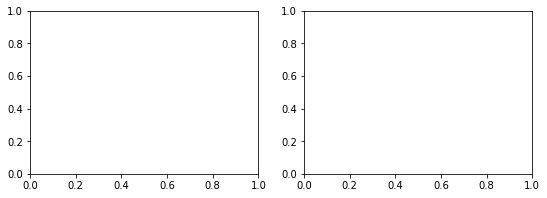

In [33]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(np.array(ll).mean(-1))

ax[1].plot(ee)

plt.show()

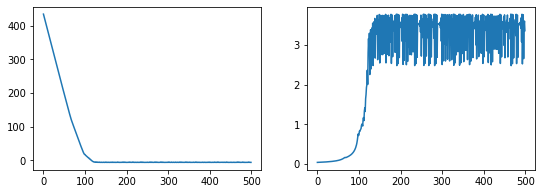

In [70]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(np.array(ll).mean(-1))

ax[1].plot(ee)

plt.show()

In [35]:
pt = p0.copy()

# ----- prepare parameters: tmp2, c, d -----
s = h * pt

tmp = 1 + np.sum(s, axis=-1) # 1 + sum beta + a
tmp2 = tmp - np.diag(s) #
fac = np.diag(s) / (tmp * tmp2)
beta = h.copy()
beta[np.diag_indices_from(beta)] = 0
grad = -(fac * beta.T).T

# r tilde constants
txp = 1.0/(mu * pt + Pc)
c1 = np.sum(grad * txp , axis=0)
c2 = -mu * np.log(np.diag(s)/tmp2+1)*txp**2
c = c1+c2 #
d = -c * pt #

# ------------------------------------------

# solve inner problem
pvar = cp.Variable(pt.shape[0])

obj_nl = cp.log(cp.multiply(np.diag(h)/tmp2, pvar)+1) @ txp ##
print(obj_nl.shape)

obj_l  = cp.multiply(c, pvar)
print(obj_l.shape)


objective = cp.Maximize(cp.sum(obj_nl + obj_l + d))
constraints = [0 <= pvar, pvar <= Pmax]
prob = cp.Problem(objective, constraints)

print('\nbefore solver:\np0={}\nee={}\n'.format(pt, f(pt,h)))

### forward function??
prob.solve(requires_grad=True, eps=1e-12, max_iters=1200, verbose=True)

print('\nafter solver:\npt={}\nee={}\n'.format(pvar.value, f(pvar.value,h)))


()
(4,)

before solver:
p0=[0.16516957 0.08670427 0.07471375 0.09479848]
ee=5.2346960417705635

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 16
eps = 1.00e-12, alpha = 1.50, max_iters = 200, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 8, constraints m = 20
Cones:	linear vars: 8
	exp vars: 12, dual exp vars: 0
Setup time: 4.08e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.24e+20  2.07e+20  1.00e+00 -1.09e+24 -1.86e+20  1.14e+24  1.15e-02 
   100| 1.92e-01  7.40e-01  9.99e-01  1.55e+03 -9.64e+01  1.42e-12  1.94e-02 
   20

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [55]:
h0 = np.array([[3.6727226e+01, 7.6416140e+00, 2.1367569e+00, 6.4129746e-01],
               [4.0369835e-01, 5.1982952e+01, 2.0964766e+00, 1.0794865e+00],
               [9.9917613e-03, 3.0490181e+00, 1.5596890e+02, 3.0584135e+00],
               [1.2896190e+00, 1.1164372e+00, 8.0090504e+00, 1.6805302e+02]])

p0 = np.array( [0.16516957, 0.08670427, 0.07471375, 0.09479848])

#
mu=4
Pc=1
Pmax = 100
h=h0.copy()
pt = p0.copy()

O1, P1 = SCA_(h, mu, Pc, Pmax, pt, SolverMaxIter=1200, MaxIter = 10000, 
              parm_alpha = 1e-8, parm_beta = 0.01, RelTolFun = 1e-12, RelTolVal = 1e-12)

print('\nbefore solver:\np0={}\nee={}\n'.format(pt, f(pt,h)))


# CONSTRAINTS = numpy.loadtxt('constraints.txt', delimiter = ',')

# x = cvxpy.Variable(26)
# list_of_constraints = [x >= 0]

# obj = cvxpy.Minimize(cvxpy.pnorm(x, 1))

# for i in range(len(CONSTRAINTS)):
#     list_of_constraints.append(1 <= numpy.transpose(CONSTRAINTS[i]) * x)

# prob = cvxpy.Problem(obj, list_of_constraints)   
# y = prob.solve()
# print(x.value)

None -outer it# 1
before solver: None [0.16516957 0.08670427 0.07471375 0.09479848]
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 16
eps = 1.00e-08, alpha = 1.50, max_iters = 1200, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 8, constraints m = 20
Cones:	linear vars: 8
	exp vars: 12, dual exp vars: 0
Setup time: 2.10e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.24e+20  2.07e+20  1.00e+00 -1.09e+24 -1.86e+20  1.14e+24  1.83e-02 
   100| 1.92e-01  7.40e-01  9.99e-01  1.55e+03 -9.64e+01  1.42e-12  2.61e-02 
   200| 9.68e-02

   100| 4.93e-01  5.59e-01  3.62e-02 -3.79e+01 -4.07e+01  3.00e-12  2.41e-02 
   200| 3.73e-02  8.75e-02  7.66e-02 -2.22e+01 -2.60e+01  1.70e-12  2.83e-02 
   300| 5.94e-07  1.86e-06  1.63e-06 -2.56e+01 -2.56e+01  8.86e-12  3.35e-02 
   360| 6.54e-09  1.40e-09  2.27e-09 -2.56e+01 -2.56e+01  1.73e-12  3.60e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.61e-02s
	Lin-sys: nnz in L factor: 44, avg solve time: 3.45e-07s
	Cones: avg projection time: 4.20e-05s
	Acceleration: avg step time: 3.34e-06s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 7.1395e-07, dist(y, K*) = 0.0000e+00, s'y/|s||y| = 2.0256e-09
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.5383e-09
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.3977e-09
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.2659e-09
----------------------------------------------------------------------------
c'x = -25.6414, -b'y =

     0| 9.24e+20  2.07e+20  1.00e+00 -1.09e+24 -1.86e+20  1.14e+24  9.97e-03 
   100| 4.81e-01  7.23e-01  9.95e-01  1.08e+02 -9.15e+01  7.26e-12  1.48e-02 
   200| 2.63e-01  2.35e-01  3.57e-01 -1.26e+01 -2.72e+01  4.36e-12  1.87e-02 
   300| 1.91e-02  3.25e-02  5.75e-02 -2.90e+01 -2.58e+01  4.52e-12  2.30e-02 
   400| 2.86e-08  2.58e-09  1.35e-07 -2.56e+01 -2.56e+01  5.99e-12  2.72e-02 
   500| 7.05e-08  4.63e-09  3.89e-08 -2.56e+01 -2.56e+01  8.26e-13  3.06e-02 
   600| 2.92e-07  3.14e-08  1.58e-07 -2.56e+01 -2.56e+01  3.43e-13  3.40e-02 
   700| 4.43e-08  3.43e-09  1.45e-08 -2.56e+01 -2.56e+01  1.43e-12  3.71e-02 
   800| 3.14e-08  2.23e-09  4.83e-09 -2.56e+01 -2.56e+01  2.55e-12  4.02e-02 
   900| 5.75e-08  4.52e-09  9.15e-08 -2.56e+01 -2.56e+01  6.58e-12  4.34e-02 
  1000| 1.86e-08  1.52e-09  7.30e-09 -2.56e+01 -2.56e+01  2.82e-12  4.65e-02 
  1100| 4.04e-08  2.93e-09  4.91e-08 -2.56e+01 -2.56e+01  6.63e-12  4.96e-02 
  1200| 1.91e-08  1.59e-09  2.38e-08 -2.56e+01 -2.56e+01  2.73e-

   700| 2.05e-08  1.56e-09  5.11e-09 -2.56e+01 -2.56e+01  2.99e-12  4.79e-02 
   800| 2.89e-08  2.34e-09  2.25e-08 -2.56e+01 -2.56e+01  1.08e-11  5.11e-02 
   900| 2.42e-08  1.56e-09  4.95e-08 -2.56e+01 -2.56e+01  1.80e-12  5.42e-02 
  1000| 3.86e-08  5.74e-09  2.85e-07 -2.56e+01 -2.56e+01  2.20e-12  5.73e-02 
  1100| 2.97e-08  2.99e-09  9.58e-08 -2.56e+01 -2.56e+01  8.14e-12  6.04e-02 
  1200| 2.71e-08  2.21e-09  1.65e-07 -2.56e+01 -2.56e+01  5.10e-12  6.35e-02 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate, returning best found solution.
Timing: Solve time: 6.35e-02s
	Lin-sys: nnz in L factor: 44, avg solve time: 2.32e-07s
	Cones: avg projection time: 3.10e-05s
	Acceleration: avg step time: 2.30e-06s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 0.0000e+00, dist(y, K*) = 0.0000e+00, s'y/|s||y| = 7.9520e-09
primal res: |Ax + s - 

     0| 9.24e+20  2.07e+20  1.00e+00 -1.09e+24 -1.86e+20  1.14e+24  3.08e-03 
   100| 3.17e-01  1.84e-01  1.46e-01 -3.36e+01 -2.49e+01  6.38e-12  8.63e-03 
   200| 9.58e-03  1.13e-02  7.57e-02 -2.20e+01 -2.57e+01  6.22e-12  1.27e-02 
   300| 4.00e-06  6.38e-06  1.52e-04 -2.56e+01 -2.56e+01  5.15e-12  1.64e-02 
   400| 4.80e-08  3.67e-09  1.43e-07 -2.56e+01 -2.56e+01  3.89e-12  1.98e-02 
   500| 7.37e-08  7.69e-09  1.86e-07 -2.56e+01 -2.56e+01  1.05e-12  2.33e-02 
   600| 2.25e-08  1.97e-09  3.01e-08 -2.56e+01 -2.56e+01  3.58e-12  2.64e-02 
   700| 4.67e-08  4.48e-09  1.50e-07 -2.56e+01 -2.56e+01  2.45e-12  2.95e-02 
   800| 1.35e-07  9.19e-09  6.52e-07 -2.56e+01 -2.56e+01  3.98e-12  3.26e-02 
   900| 2.18e-08  1.73e-09  7.37e-09 -2.56e+01 -2.56e+01  4.25e-12  3.57e-02 
  1000| 2.49e-08  2.16e-09  4.56e-08 -2.56e+01 -2.56e+01  1.13e-12  3.88e-02 
  1100| 2.58e-08  2.37e-09  5.27e-08 -2.56e+01 -2.56e+01  2.99e-12  4.18e-02 
  1200| 4.62e-08  3.49e-09  7.40e-08 -2.56e+01 -2.56e+01  1.93e-

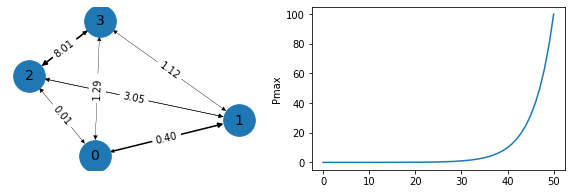

TypeError: object of type 'numpy.float64' has no len()

In [20]:
H = np.array(h)
np.fill_diagonal(H, 0)

G = nx.from_numpy_matrix(H, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])

edges = G.edges()
weights = [G[u][v]['weight']/5 for u,v in edges]

plt.figure(figsize=(10,3))
plt.subplot(121)
nx.draw(G, pos, node_size=1000,font_size=14,
        width=weights, with_labels=True) 
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.subplot(122)
plt.plot(Plin)
plt.ylabel('Pmax')
plt.show()



for i, (oo1, oo2) in enumerate(zip(MONITOR['O1'], MONITOR['O2'])):
    if oo1[-1] > oo2[-1]:
        print('adapt:\t', '#iters: (%d=%d+%d)\t'%(len(oo1)+len(oo2), len(oo1), len(oo2)),
             'discrepency: %.2f>%.2f\t'%(oo1[-1], oo2[-1]), 
              'pt:',np.round(MONITOR['P1'][i][-1],3), '\tPmax: %f'%Plin[i])
    else:
        print('max\t', '#iters: (%d=%d+%d)\t'%(len(oo1)+len(oo2), len(oo1), len(oo2)),
             'discrepency: %.2f<%.2f\t'%(oo1[-1], oo2[-1]), 
             'pt:',np.round(MONITOR['P2'][i][-1],3), '\tPmax: %f'%Plin[i])



In [17]:
MONITOR['objective']['rand']

[1.454651487033575, 2.7812018362798265]

3

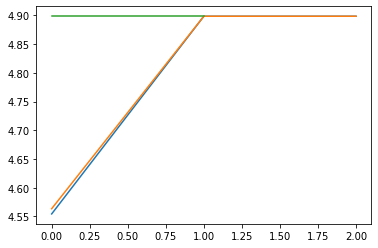

In [42]:
plt.plot(MONITOR['O1'][3])
plt.plot(MONITOR['O3'][3])
plt.plot(MONITOR['O2'][3])
len(MONITOR['O3'][3])

In [ ]:
H = np.array(h)
np.fill_diagonal(H, 0)

G = nx.from_numpy_matrix(H, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])

edges = G.edges()
weights = [G[u][v]['weight']/5 for u,v in edges]

plt.figure(figsize=(10,3))
plt.subplot(121)
nx.draw(G, pos, node_size=1000,font_size=14,
        width=weights, with_labels=True) 
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.subplot(122)
plt.plot(Plin)
plt.ylabel('Pmax')
plt.show()



for i, (oo1, oo2) in enumerate(zip(MONITOR['O1'], MONITOR['O2'])):
    if oo1[-1] > oo2[-1]:
        print('adapt:\t', '#iters: (%d=%d+%d)\t'%(len(oo1)+len(oo2), len(oo1), len(oo2)),
             'discrepency: %.2f>%.2f\t'%(oo1[-1], oo2[-1]), 
              'pt:',np.round(MONITOR['P1'][i][-1],3), '\tPmax: %f'%Plin[i])
    else:
        print('max\t', '#iters: (%d=%d+%d)\t'%(len(oo1)+len(oo2), len(oo1), len(oo2)),
             'discrepency: %.2f<%.2f\t'%(oo1[-1], oo2[-1]), 
             'pt:',np.round(MONITOR['P2'][i][-1],3), '\tPmax: %f'%Plin[i])


In [ ]:
pt

In [ ]:
MONITOR['P2'][i][-1].tolist()

In [ ]:

import matplotlib.pyplot as plt
import networkx as nx

# plt.plot(MONITOR['obj'])

len([len(o) for o in MONITOR['obj']])

In [ ]:
!pip install networkx


In [ ]:
plt.plot(Plin)

In [ ]:
print(o1,p1)
print(o2,p2)

In [ ]:
#     import progressbar as pb
from tqdm import tqdm
from tqdm.auto import trange
import itertools as it
import h5py

num_ue = 4

dfn = '../../data/wsee%d-processed.h5'%num_ue
mu = 4
Pc = 1

f = h5py.File(dfn, 'r')
dset = f

Plin = 10**(np.asarray(dset['input/PdB'][...]/10))

try:
    obj = dset.create_dataset('SCA', shape = dset['objval'].shape, fillvalue = np.nan, dtype = dset['objval'].dtype)
    popt = dset.create_dataset('SCA_xopt', shape = dset['objval'].shape + (4,), fillvalue = np.nan, dtype = dset['objval'].dtype)
    obj2 = dset.create_dataset('SCAmax', shape = dset['objval'].shape, fillvalue = np.nan, dtype = dset['objval'].dtype)
    popt2 = dset.create_dataset('SCAmax_xopt', shape = dset['objval'].shape + (4,), fillvalue = np.nan, dtype = dset['objval'].dtype)
except:# RuntimeError:
    print('IN EXCEPTION!!')
    obj = dset['SCA']
    popt = dset['SCA_xopt']
    obj2 = dset['SCAmax']
    popt2 = dset['SCAmax_xopt']

obj_ = np.full_like(obj, np.nan)
popt_ =  np.full_like(popt, np.nan)
obj2_ = np.full_like(obj2, np.nan)
popt2_ =  np.full_like(popt2, np.nan)

#     for cidx, pidx in pb.progressbar(it.product(range(11907,20000), range(obj.shape[1])), widget = pb.ETA, max_value = (20000-11907)*obj.shape[1]):
#     for cidx, pidx in tqdm(it.product(range(11907,12200), range(obj.shape[1])), total = (12200-11907)*obj.shape[1]):
for cidx in trange(20,21,desc='channel index:'):
    for pidx in trange(obj.shape[1], desc='power index:'):

        # cidx- channel matrix realization ~xxx
        # pidx- power limit realization ~51

        h = np.asarray(dset['input/channel_to_noise_matched'][cidx], dtype = float)
        p = Plin[pidx]

        if pidx == 0:
            pt = None

        if pt is not None:
            o1,p1 = SCA(h, mu, Pc, Pmax = p, pt = pt, 
                        MaxIter = 10000, parm_alpha = 1e-8, parm_beta = 0.01, RelTolFun = 1e-12, RelTolVal = 1e-12)
        else:
            o1 = -np.inf

        o2,p2 = SCA(h, mu, Pc, Pmax = p, pt = np.full(num_ue, p), 
                    MaxIter = 10000, parm_alpha = 1e-8, parm_beta = 0.01, RelTolFun = 1e-12, RelTolVal = 1e-12)

        obj2_[cidx,pidx] = o2 # f(pt)
        popt2_[cidx,pidx,:] = p2

        if o1 > o2:
            print(pidx,1)
            obj_[cidx,pidx] = o1
            pt = p1
        else:
            print(pidx,2)
            obj_[cidx,pidx] = o2
            pt = p2

        popt_[cidx,pidx,:] = pt

        if pidx > 51:
            print(cidx, pidx)
            break

#         if cidx > 51
#             print(cidx, pidx)
#             break

print(obj_[np.any(~np.isnan(obj_), axis=-1)])




f.close()

In [ ]:
popt_[np.any(~np.isnan(obj_), axis=-1)]

In [ ]:

import matplotlib.pyplot as plt
import networkx as nx

H = np.array(h)
np.fill_diagonal(H, 0)

G = nx.from_numpy_matrix(H, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])


edges = G.edges()
weights = [G[u][v]['weight']/5 for u,v in edges]


nx.draw(G, pos, node_size=1000,font_size=14,
        width=weights, with_labels=True) 
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# plt.tight_layout()
plt.show()

In [ ]:
np.round(H,1).tolist()

In [ ]:

import matplotlib.pyplot as plt

ee_corr = obj_[np.any(~np.isnan(obj_), axis=-1)]
power_alloc = popt_[np.any(~np.isnan(obj_), axis=-1)]

# print(popt_[np.any(~np.isnan(obj_), axis=-1)])

# plt.plot(ee_corr.T)
plt.plot(power_alloc[0])
# plt.plot(Plin)
plt.yscale('log')

print(np.diag(h))

In [ ]:
plt.bar(range(4),power_alloc[0][0,:])
# plt.plot(np.diag(h)/np.sum(np.diag(h))*np.max(power_alloc[0][-1,:]),'r')

In [ ]:
power_alloc[0][0,:]